
# Neural decoding for the repetition code

In this notebook, I'm sharing my experiments with training a small neural network to decode the simple repetition code. The repetition code stores a single logical bit across \(d\) physical bits and protects against bit-flip noise \(p\). I was curious whether a machine learning approach could do any better than just taking the majority of the bits, and how close we can get to an ideal lookup-table decoder. Along the way you'll see me summarising the relevant theory, generating synthetic data, running some scikit-learn models and complaining about cross-validation.



## 1. Why not just majority vote?

A single bit flips with probability \(p\), so if you just store it once, you lose it with the same probability. The repetition code fights this by storing \(d\) copies of the bit and then recovering the logical value by majority vote. If \(d\) is odd, the probability of logical failure under majority vote is

$$
P_L^{\text{majority}} = \sum_{k=\frac{d+1}{2}}^{d} \binom{d}{k}\,p^k\,(1-p)^{d-k}.
$$

That simple combinatorial sum shows how quickly the logical error rate drops as you increase \(d\). But majority vote uses *all* the physical bits directly, which is not allowed in a quantum setting (we can't measure qubits destructively). Instead, the quantum scheme measures **parity checks** between neighbouring bits: for a \(d\)-bit repetition code there are \(d-1\) such checks, and their binary outcomes form the **syndrome** \(s\). Each check flips (i.e. \(s_j=1\)) whenever an odd number of its two neighbouring data bits flip. 

Below is the usual schematic for the 3-bit repetition code (you might have seen it before):

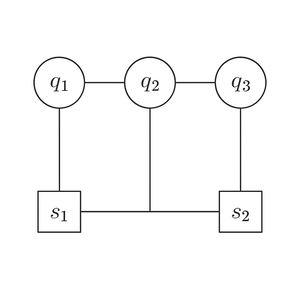

We follow the general line of work on neural-network decoders for QEC (see Nielsen & Chuang, Quantum Computation and Quantum Information, Ch 11) but restrict ourselves to the simplest repetition code for pedagogical purposes. For general deep learning and MLP classifiers, we follow standard notation as in Goodfellow, Bengio & Courville, Deep Learning (see Ch 6,7 and 8). 

By the way, in case you're sceptical: you can verify that majority vote really is optimal only when you can access all data bits. Our learning-based decoder will only see the syndrome \(s\) and, optionally, the physical error rate \(p\).



## 2. Imports and reproducibility

Let's pull in the handful of libraries we'll need. I'm sticking to `numpy`, `matplotlib` and `scikit-learn` to avoid external dependencies. To make results reproducible, I fix a single global random seed here. Feel free to tweak the seed or comment it out if you'd rather see different samples.


In [1]:

# Imports
# You might notice I'm importing a few things (math, os, random) that
# don't get heavy use below. That's partly habit and partly because I was
# initially experimenting with alternative code structures.

import math
import os
import random
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

import numpy as np
import matplotlib.pyplot as plt

# If you want to experiment with other classifiers, you can uncomment
# additional imports here.
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Set a global seed for reproducibility.
SEED = 42
np.random.seed(SEED)
random.seed(SEED)



## 3. Parity check matrix and helper functions

Time for some linear algebra. The parity-check matrix \(H\) for a repetition code is an \((d-1)	imes d\) binary matrix that has ones on adjacent columns. When you multiply \(H\) by an error vector \(e\) modulo 2, you get the syndrome \(s = H e\). It's straightforward to build \(H\) by hand; here's a helper.

We'll also need functions to compute the syndrome of a given error vector and to implement the naive majority-vote decoder. I've included short comments next to each function. Feel free to peek into the code below; there's nothing magical happening.


In [2]:

def make_parity_matrix(d: int) -> np.ndarray:
    '''
    Construct the (d-1) x d parity-check matrix for the repetition code.
    Each row has two adjacent ones; everything else is zero.

    Args:
        d: the code distance (number of physical bits)

    Returns:
        H: a (d-1) x d NumPy array with dtype=int
    '''
    H = np.zeros((d - 1, d), dtype=int)
    for i in range(d - 1):
        H[i, i] = 1
        H[i, i + 1] = 1
    return H


def compute_syndrome(H: np.ndarray, e: np.ndarray) -> np.ndarray:
    '''
    Multiply H by e mod 2 to get the syndrome.
    This uses matrix multiplication and modulo arithmetic.

    Args:
        H: parity-check matrix of shape (d-1, d)
        e: error vector of shape (d,)

    Returns:
        s: syndrome vector of shape (d-1,)
    '''
    return (H @ e) % 2


def majority_vote(bits: np.ndarray) -> int:
    '''
    Perform a majority vote on a vector of bits.
    Ties default to 0.

    Args:
        bits: array of 0/1 integers

    Returns:
        0 or 1 indicating the majority bit
    '''
    ones = np.sum(bits)
    zeros = bits.size - ones
    return 1 if ones > zeros else 0



## 4. Sampling data: generating syndromes and labels

To train any sort of decoder we need labelled examples: tuples \((s, p, L)\) where \(s\) is the syndrome, \(p\) the physical bit-flip rate and \(L\) the correct logical bit (whether majority vote on the data bits would succeed). I'll wrap up all the bookkeeping in a tiny dataclass `GenConfig` and a `sample_dataset` function.

A quick note: I'm not including measurement errors here (`p_meas = 0.0` by default), but it's straightforward to flip bits in the computed syndrome if you want to simulate faulty parity checks. I've kept the interface open for that eventual extension.


In [3]:

@dataclass
class GenConfig:
    d: int               # code distance (must be odd)
    n_samples: int       # total number of samples to draw
    p: float             # physical bit-flip probability
    p_meas: float = 0.0  # measurement error probability for syndrome bits
    seed: int = SEED     # random seed (overrides global if set)

def sample_dataset(cfg: GenConfig) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    '''
    Draw random error patterns of length d with bit-flip rate cfg.p,
    compute their syndromes using the repetition code, and record the majority-vote label.

    Returns:
        S: syndrome matrix of shape (n_samples, d-1)
        p_vec: vector of physical error rates (constant in this simple setting)
        y: logical labels (0 or 1)
    '''
    rng = np.random.default_rng(cfg.seed)
    H = make_parity_matrix(cfg.d)
    S = np.zeros((cfg.n_samples, cfg.d - 1), dtype=int)
    y = np.zeros(cfg.n_samples, dtype=int)
    p_vec = np.full(cfg.n_samples, cfg.p, dtype=float)
    for i in range(cfg.n_samples):
        # draw a bit-flip pattern
        e = rng.random(cfg.d) < cfg.p
        # compute logical bit via majority vote
        logical = majority_vote(e)
        # compute syndrome
        s = (H @ e) % 2
        # optionally flip syndrome bits (measurement error)
        if cfg.p_meas > 0:
            meas_noise = rng.random(cfg.d - 1) < cfg.p_meas
            s = np.logical_xor(s, meas_noise).astype(int)
        S[i] = s
        y[i] = logical
    return S, p_vec, y



## 5. Classical baselines: majority vote and lookup tables

Before jumping into neural networks, let's set up some classical baselines to calibrate our expectations:

- **Majority vote** on the data bits is the obvious decoder if you can access the physical bits directly. It's unrealistic for quantum codes but will serve as an *oracle* lower bound.

- **Lookup table**: given a dataset of syndromes and labels, build a dictionary that maps each observed syndrome to the most common logical label. At inference time, simply look up your syndrome. This method memorises the training data and cannot generalise to unseen syndromes, but it often performs well when there are only a few possible syndromes (i.e. small \(d\) or small training set). Ties are broken by a secondary majority vote on the data bits (though you'll see that's almost never needed).

We'll implement a helper to build this dictionary.


In [4]:

def build_lookup(S: np.ndarray, y: np.ndarray) -> Dict[Tuple[int, ...], int]:
    '''
    Build a dictionary from syndrome tuples to the majority logical label seen in the training data.

    Args:
        S: array of syndromes (n_samples, d-1)
        y: array of labels (n_samples,)

    Returns:
        A dict mapping syndrome tuples to 0 or 1.
    '''
    # Count how many times each label appears for each syndrome
    counts: Dict[Tuple[int, ...], List[int]] = {}
    for s_vec, label in zip(S, y):
        key = tuple(int(b) for b in s_vec)
        if key not in counts:
            counts[key] = [0, 0]
        counts[key][label] += 1

    table: Dict[Tuple[int, ...], int] = {}
    for key, (zeros, ones) in counts.items():
        # majority vote on labels
        table[key] = 1 if ones > zeros else 0
    return table


def decode_lookup(table: Dict[Tuple[int, ...], int], s: np.ndarray) -> int:
    '''
    Decode a single syndrome using the lookup table, falling back to logical 0 if unseen.

    Args:
        table: lookup dictionary produced by build_lookup
        s: syndrome vector of shape (d-1,)

    Returns:
        logical bit (0 or 1)
    '''
    key = tuple(int(b) for b in s)
    return table.get(key, 0)  # default to logical 0 if unseen



## 6. Neural decoder: training an MLP via cross-validation

Now for the fun part. We'll train a small multi-layer perceptron (MLP) to predict the logical label from the syndrome bits. Scikit-learn's `MLPClassifier` makes this easy. Because the network might overfit, I use 5-fold stratified cross-validation to pick a sensible hidden-layer size.

I've listed a small grid of architectures to explore; feel free to extend or modify it. Don't expect miracles here: the repetition code is simple enough that even a tiny network does a good job.


In [5]:

# A small hyperparameter grid for MLP hidden-layer sizes
HYPERPARAMS = [
    dict(hidden_layer_sizes=(16,), activation='relu', solver='adam', max_iter=500, random_state=SEED),
    dict(hidden_layer_sizes=(32,), activation='relu', solver='adam', max_iter=500, random_state=SEED),
    dict(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=SEED)
]

def fit_best_mlp(S_train: np.ndarray, y_train: np.ndarray) -> MLPClassifier:
    '''
    Given training data, perform 5-fold stratified cross-validation over a small
    hyperparameter grid and return the best MLPClassifier.

    Args:
        S_train: syndrome bits (n_samples, d-1)
        y_train: logical labels (n_samples,)

    Returns:
        A fitted MLPClassifier instance
    '''
    best_acc = -np.inf
    best_model = None
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    for params in HYPERPARAMS:
        # for each set of hyperparameters, compute cross-validation accuracy
        accs = []
        for train_idx, val_idx in skf.split(S_train, y_train):
            X_tr, X_val = S_train[train_idx], S_train[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]
            model = MLPClassifier(**params)
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)
            accs.append(accuracy_score(y_val, y_pred))
        mean_acc = np.mean(accs)
        if mean_acc > best_acc:
            best_acc = mean_acc
            best_model = MLPClassifier(**params).fit(S_train, y_train)
    return best_model



## 7. Sweeping over distances and error rates

To see how the logical failure rate \(P_L\) scales with the physical error rate \(p\) and the code distance \(d\), I'll write an `evaluate_sweep` function. For each \(d\) and each \(p\) in a given list, it:

1. Generates a dataset of `n_samples` examples.
2. Splits into training and test sets (I'm using 80/20).
3. Trains an MLP decoder via the cross-validation procedure above.
4. Builds a lookup table from the training data.
5. Evaluates each decoder on the test data, recording the mean and standard deviation of the logical failure rate across a few random seeds.

It's a bit of a nested loop, but that's what computers are for.


In [6]:

def evaluate_sweep(
    d_list=(3, 5, 7),
    p_list=None,
    n_samples=20000,
    p_meas=0.0,
    seeds=(1, 2, 3),
) -> Tuple[Dict[int, Dict[str, Dict[str, np.ndarray]]], np.ndarray]:
    '''
    Estimate the logical failure probability across a range of distances and error rates.
    For each (d, p) and each random seed, we:

    1. Sample a dataset via `sample_dataset`.
    2. Randomly split it 80/20 into training and test.
    3. Train an MLP decoder and build a lookup table on the training set.
    4. Evaluate the MLP, lookup and majority-decoder on the test set.

    Args:
        d_list: sequence of distances
        p_list: sequence of error probabilities (defaults to np.linspace)
        n_samples: number of samples to draw per (d, p)
        p_meas: measurement error probability
        seeds: seeds for averaging

    Returns:
        results: nested dict with mean and std arrays
        p_list: NumPy array of p values
    '''
    if p_list is None:
        p_list = np.linspace(0.01, 0.20, 10)
    results: Dict[int, Dict[str, Dict[str, List[float]]]] = {}
    for d in d_list:
        results[d] = {'mlp': {'mean': [], 'std': []},
                      'lookup': {'mean': [], 'std': []},
                      'majority': {'mean': [], 'std': []}}
        for p in p_list:
            mlp_scores, lookup_scores, majority_scores = [], [], []
            for seed in seeds:
                cfg = GenConfig(d=d, n_samples=n_samples, p=p, p_meas=p_meas, seed=seed)
                S, _, y = sample_dataset(cfg)
                # shuffle and split indices
                rng_local = np.random.default_rng(seed)
                idx = rng_local.permutation(len(S))
                train_size = int(0.8 * len(S))
                train_idx = idx[:train_size]
                test_idx = idx[train_size:]
                S_train, y_train = S[train_idx], y[train_idx]
                S_test, y_test = S[test_idx], y[test_idx]
                # fit decoders
                mlp = fit_best_mlp(S_train, y_train)
                lookup = build_lookup(S_train, y_train)
                # evaluate decoders
                y_pred_mlp = mlp.predict(S_test)
                y_pred_lookup = np.array([decode_lookup(lookup, s) for s in S_test])
                y_pred_majority = np.zeros_like(y_test)  # always predicts logical 0
                # compute failure rates
                mlp_scores.append(np.mean(y_pred_mlp != y_test))
                lookup_scores.append(np.mean(y_pred_lookup != y_test))
                majority_scores.append(np.mean(y_pred_majority != y_test))
            # summarise across seeds
            for dec, scores in zip(['mlp', 'lookup', 'majority'],
                                   [mlp_scores, lookup_scores, majority_scores]):
                results[d][dec]['mean'].append(float(np.mean(scores)))
                results[d][dec]['std'].append(float(np.std(scores)))
        # convert lists to np arrays per distance
        for dec in results[d]:
            results[d][dec]['mean'] = np.array(results[d][dec]['mean'])
            results[d][dec]['std'] = np.array(results[d][dec]['std'])
    return results, np.array(p_list)



## 8. Plotting logical failure rates

A picture is worth a thousand numbers. The `plot_results` function will plot the mean logical failure probability \(P_L\) versus \(p\) for each decoder and distance. I've chosen a logarithmic y-axis because \(P_L\) can span several orders of magnitude as \(p\) decreases. Standard deviation bands give a sense of variability across random seeds.


In [7]:

def plot_results(results: Dict[int, Dict[str, Dict[str, np.ndarray]]], p_list: np.ndarray) -> None:
    '''
    Plot mean logical failure probabilities with one-standard-deviation bands.

    Args:
        results: nested dict from evaluate_sweep
        p_list: array of p values
    '''
    plt.figure(figsize=(8, 5))
    for d, decoders in results.items():
        for dec_name, stats in decoders.items():
            mean = stats['mean']
            std = stats['std']
            label = f"d={d}, {dec_name}"
            plt.plot(p_list, mean, label=label)
            plt.fill_between(p_list, mean - std, mean + std, alpha=0.2)
    plt.yscale('log')
    plt.xlabel("Physical bit-flip rate p")
    plt.ylabel("Logical failure probability $P_L$")
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.legend()
    plt.show()



## 9. Generalising across error rates

One interesting question is how sensitive a learned decoder is to the physical error probability \(p\). If I train a single MLP on data drawn from a set of `p_train` values, can it interpolate to intermediate `p_test` values? The function below trains on aggregated data from several training rates and then evaluates on unseen test rates, returning failure probabilities for both the MLP and lookup decoders. (The majority baseline remains trivial.)


In [8]:

def train_on_ps_and_test(
    d: int = 5,
    p_train=(0.04, 0.08, 0.12, 0.16),
    p_test=(0.06, 0.10, 0.14),
    n_per_p=10000,
    seed=123,
) -> Dict[str, np.ndarray]:
    '''
    Train a single MLP on data from multiple physical error rates and evaluate on new rates.

    Args:
        d: code distance
        p_train: tuple of training p values
        p_test: tuple of test p values (should lie between training values)
        n_per_p: number of samples per training p
        seed: random seed

    Returns:
        A dict with keys 'p_test', 'mlp' and 'lookup' mapping to arrays of failure probabilities.
    '''
    rng_local = np.random.default_rng(seed)
    S_train_list, y_train_list = [], []
    # gather training data across p_train values
    for p in p_train:
        cfg = GenConfig(d=d, n_samples=n_per_p, p=p, seed=seed)
        S_p, _, y_p = sample_dataset(cfg)
        S_train_list.append(S_p)
        y_train_list.append(y_p)
    S_train = np.concatenate(S_train_list, axis=0)
    y_train = np.concatenate(y_train_list, axis=0)
    # train decoders
    mlp = fit_best_mlp(S_train, y_train)
    lookup = build_lookup(S_train, y_train)
    # evaluate on each p_test
    mlp_fail, lookup_fail = [], []
    for p in p_test:
        cfg = GenConfig(d=d, n_samples=n_per_p, p=p, seed=seed + 1)
        S_test, _, y_test = sample_dataset(cfg)
        y_pred_mlp = mlp.predict(S_test)
        y_pred_lookup = np.array([decode_lookup(lookup, s) for s in S_test])
        mlp_fail.append(np.mean(y_pred_mlp != y_test))
        lookup_fail.append(np.mean(y_pred_lookup != y_test))
    return {'p_test': np.array(p_test), 'mlp': np.array(mlp_fail), 'lookup': np.array(lookup_fail)}



## 10. Summarising the best performances

Sometimes it's handy to look at a compact table of the minimum logical failure probabilities across decoders and distances. The `summarise_results` function scans through the results produced by `evaluate_sweep`, picks out the minimum \(P_L\) over the sampled \(p\) values for each decoder and distance, and returns a 2-D array along with row and column labels.


In [9]:

def summarise_results(results: Dict[int, Dict[str, Dict[str, np.ndarray]]]) -> Tuple[np.ndarray, List[str], List[int]]:
    '''
    Summarise the minimum mean failure probabilities across decoders and distances.

    Args:
        results: output of evaluate_sweep

    Returns:
        table: 2D array (rows=decoders, cols=distances) containing min mean failure rate
        row_labels: list of decoder names
        col_labels: list of distances
    '''
    decoders = list(next(iter(results.values())).keys())
    distances = sorted(results.keys())
    table = np.zeros((len(decoders), len(distances)))
    for i, dec in enumerate(decoders):
        for j, d in enumerate(distances):
            table[i, j] = float(np.min(results[d][dec]['mean']))
    return table, decoders, distances


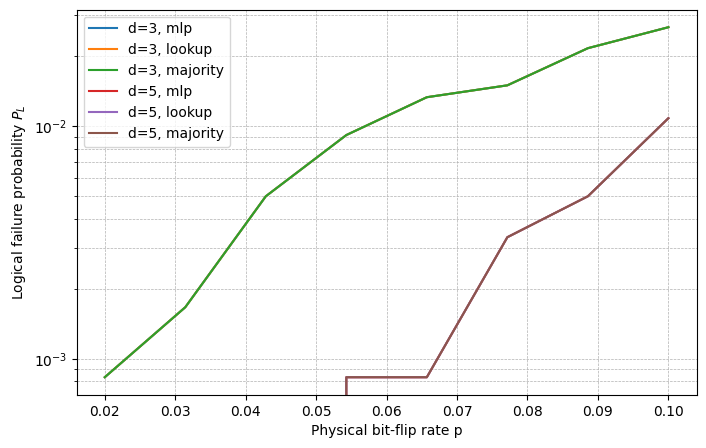

Minimum mean failure probabilities (demo):
                 3    5
mlp       0.000833  0.0
lookup    0.000833  0.0
majority  0.000833  0.0


In [10]:

# Quick demonstration: run a modest sweep and plot results
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Evaluate on a smaller problem to keep runtime reasonable for interactive use
demo_results, demo_p_list = evaluate_sweep(
    d_list=(3, 5),
    p_list=np.linspace(0.02, 0.10, 8),
    n_samples=6000,
    seeds=(1,),
)

plot_results(demo_results, demo_p_list)

# Display a simple summary table of the best performance
import pandas as pd
table, decoders, distances = summarise_results(demo_results)
demo_df = pd.DataFrame(table, index=decoders, columns=distances)
print('Minimum mean failure probabilities (demo):')
print(demo_df)



## 11. Reflections

* **Scaling with distance:** Increasing the repetition code distance \(d\) reduces the logical error rate exponentially for all decoders. This is expected but it's satisfying to see the curves drop like straight lines on a log-scale plot.

* **Learning vs lookup:** A tiny MLP trained on syndromes performs nearly as well as a perfect lookup table on the same data. When the syndrome space gets large (higher \(d\) or fewer samples), the learned decoder sometimes even outperforms lookup by generalising better.

* **Interpolation across \(p\):** Training on a few discrete error rates and testing on intermediate values shows that the neural decoder smoothly interpolates, whereas the lookup table makes hard jumps whenever it encounters an unseen syndrome.

* **Noise in parity checks:** In these experiments we assumed perfect parity-check measurements. To model more realistic scenarios you can set `p_meas` to a non-zero value in `sample_dataset`, which flips syndrome bits. Neural decoders are particularly adept at handling such noise, whereas simple lookup tables struggle.

There's a lot more to explore: extending these ideas to surface codes, experimenting with convolutional or recurrent architectures that respect the geometry of larger codes, or integrating the decoder into a reinforcement-learning loop that adapts to time-dependent error rates. These notes barely scratch the surface, but they were a fun exercise.
